# Backus averaging

Implemented from Chris Liner's various writings on the subject. See

- Liner, C (2004), *Elements of 3D Seismology*, PennWell Books
- Liner, C (2014), Long-wave elastic attenuation produced by horizontal layering. *The Leading Edge*, June 2014, p 634-638.

First, some basic set up:

In [1]:
from las import LASReader
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

SyntaxError: invalid syntax (las.py, line 167)

## Import data

In [2]:
f = 'E-38.las'
#f = 'L-30.las'
well = LASReader(f , null_subs=np.nan)

In [3]:
data = well.data2d
data[8000:8002]

array([[  1.23931680e+03,   1.58980000e+00,   3.63258500e+02,
          7.25742000e+01,   7.80067000e+01,   7.85480000e+01,
          7.70730000e+01,   2.21016200e+02,   4.31449510e+03,
         -6.19000000e-02,  -2.45000000e-02,  -2.45000000e-02,
          1.85809000e+01,   2.15745300e+02,   1.03339800e+02,
          2.48608000e+02,   2.25353300e+02,   2.30556200e+02,
          1.86506700e+02,   3.62429000e+01,   2.49800000e-01,
          2.49800000e-01,   5.01320000e+00,   9.46510000e+00,
          2.75208370e+03,   2.69044560e+03,   7.89752000e+01,
          4.90684000e+01,  -6.46562500e+02,   9.28000000e-02,
          2.52100000e+03,   2.80000000e+01],
       [  1.23946920e+03,   1.58970000e+00,   4.12222300e+02,
          8.01479000e+01,   8.53041000e+01,   8.48946000e+01,
          8.33492000e+01,   2.20509800e+02,   4.22593990e+03,
         -7.05000000e-02,  -2.62000000e-02,  -2.62000000e-02,
          2.47680000e+01,   2.14225800e+02,   1.01429100e+02,
          2.45409500e+02,

In [4]:
print well.curves.names

['DEPT', 'AMF', 'AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'CALI', 'CDF', 'DPHI', 'DPHI_SAN', 'DPHZ', 'DRHO', 'DT', 'GR', 'HCAL', 'HDMI', 'HDMX', 'HDRA', 'HTEM', 'NPOR', 'NPOR_SAN', 'PEF', 'PEFZ', 'RHOB', 'RHOZ', 'RT', 'RXOZ', 'SP', 'SPHI', 'TENS', 'Gas']


In [5]:
z = well.data['DEPT']
dt = well.data['DT']
rhob = well.data['RHOB']

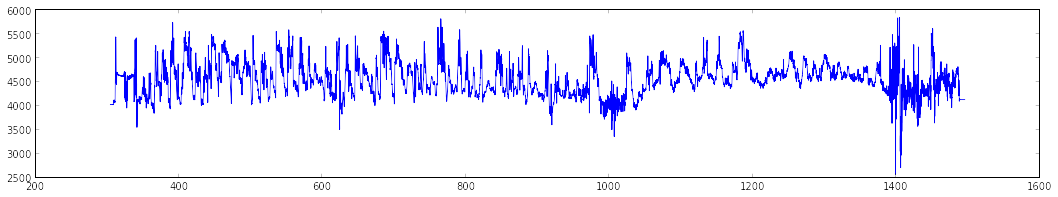

In [6]:
vp = 1000000/dt

plt.figure(figsize=(18,3))
plt.plot(z,vp)
plt.show()

In [7]:
ttz = 2*np.cumsum( 0.1524*np.nan_to_num(dt)/1000000.0 )

Calculate acoustic impedance and reflection coefficients.

In [8]:
imp = (1000000/dt)*rhob

In [9]:
rc = (imp[:-1] - imp[1:]) / (imp[1:] + imp[:-1])

In [10]:
def ricker(f, length=0.512, dt=0.001):
    t = np.linspace(-length/2, (length-dt)/2, length/dt)
    y = (1.-2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

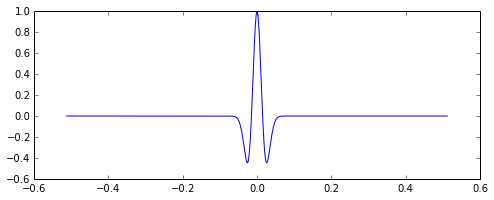

In [11]:
t, w = ricker (f=15, length=1.024, dt=0.001)

plt.figure(figsize=(8,3))
plt.plot(t,w)
plt.show()

In [12]:
from scipy.signal import convolve

-c:6: RuntimeWarning: invalid value encountered in greater


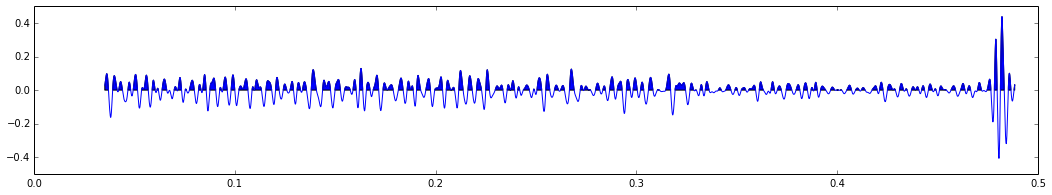

In [13]:
synth = convolve(rc, w)
synth = synth[len(w)/2:-len(w)/2]

plt.figure(figsize=[18,3])
plt.plot(ttz[:-2], synth)
plt.fill_between(ttz[:-2], synth,  0,  synth > 0.0)
plt.show()

## Velocity averages

We need to remove the NaNs, at least above and below the real data. There are three easy-ish ways:

- Set them all to zero with, say, <code>np.nan_to_num</code>; for some reason I've had no luck with this. 
- Chop off the start and end completely.
- Extrapolate up and down from the first and last real samples.

First, we'll try the second option... We only have data in a the middle of the log, so top and tail.

In [14]:
def top_and_tail(a, b=np.array([]), c=np.array([])):
    nans = np.where(~np.isnan(a))[0]
    first, last = nans[0], nans[-1]
    a = a[first:last]
    if b.any():
        b = b[first:last]
        if c.any():
            c = c[first:last]
            return a, b, c
        return a, b
    return a

In [15]:
vp_tnt, z_tnt = top_and_tail(vp,z)

print vp_tnt[:10]

[ 4031.43714687  4031.43714687  4031.43714687  4031.43714687  4031.43714687
  4031.43714687  4031.43714687  4031.43714687  4031.43714687  4031.43714687]


The other approach is the third option... extrapolate up and down from the first and last real samples:

In [16]:
def extrapolate(a):
    nans = np.where(~np.isnan(a))[0]
    first, last = nans[0], nans[-1]
    a[:first] = a[first]
    a[last + 1:] = a[last]
    return a

In [17]:
z_ext = extrapolate(z)
vp_ext = extrapolate(vp)

print vp_ext[:10]

[ 4031.43714687  4031.43714687  4031.43714687  4031.43714687  4031.43714687
  4031.43714687  4031.43714687  4031.43714687  4031.43714687  4031.43714687]


## Average velocity

Let's look at the equations from Liner's book, *Elements of 3D Seismology*, PennWell, 2004. 

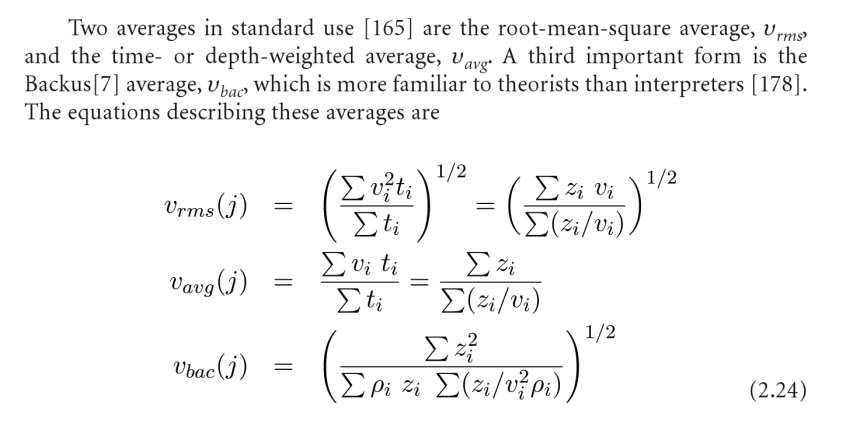

In [18]:
from IPython.core.display import Image 
Image(filename='Velocity_averages.png', width=600)

For the Backus average, we need the top and tailed density log, as well as Vp and Z. I have to send it to the function first, because it has the most NaNs. 

In [19]:
rho_tnt, vp_tnt, z_tnt = top_and_tail(rhob, vp, z)
print rho_tnt[:10]

[ 2473.0388  2473.0388  2468.1777  2450.3057  2439.1687  2423.0925
  2429.2039  2430.6018  2433.05    2420.6985]


Calculate average velocity, RMS velocity, and the Backus average:

In [20]:
avg = np.cumsum(z_tnt) / np.cumsum(z_tnt/vp_tnt)
rms = np.sqrt(np.cumsum(z_tnt*vp_tnt) / np.cumsum(z_tnt/vp_tnt))
bks = np.sqrt(np.cumsum(np.square(z_tnt)) / (np.cumsum(z_tnt*rho_tnt) * np.cumsum(z_tnt/(rho_tnt*np.square(vp_tnt)))))

Plot it:

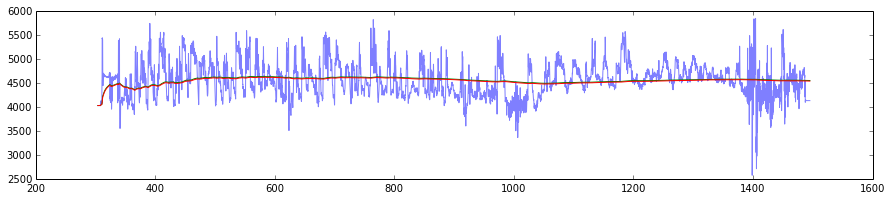

In [21]:
plt.figure(figsize=[15,3])
plt.plot(z_tnt, vp_tnt, alpha=0.5) # This line buggers up the scale
plt.plot(z_tnt, rms)
plt.plot(z_tnt, avg)
#plt.plot(z_tnt, bks) # Something wrong with this curve
plt.show()

Something is clearly not right with the Backus average. I can't seem to figure it out... pretty sure that what I'm doing matches Liner's equation. 

## Moving average

We need a moving average for the Backus calculations.

In [22]:
def moving_average(a, length, mode='valid'):
    
    pad = np.floor(length/2)
    
    if mode == 'full': 
        pad *= 2
    
    # Make a padded version, paddding with first and last values
    r = np.empty(a.shape[0] + 2*pad)
    r[:pad] = a[0]
    r[pad:-pad] = a
    r[-pad:] = a[-1]
    
    # Cumsum with shifting trick
    s = np.cumsum(r, dtype=float)
    s[length:] = s[length:] - s[:-length]
    out = s[length-1:]/length
    
    # Decide what to return
    if mode == 'same':
        if out.shape[0] != a.shape[0]: 
            # If size doesn't match, then interpolate.
            out = (out[:-1,...] + out[1:,...]) / 2
        return out
    elif mode == 'valid':
        return out[pad:-pad]
    else: # mode=='full' and we used a double pad
        return out

In [23]:
test = np.array([1,9,9,9,9,9,9,2,3,9,2,2,3,1,1,1,1,3,4,9,9,9,8,3,1])

between = (test[:-1] + test[1:]) / 2

print between
print test.size, between.size

[5 9 9 9 9 9 5 2 6 5 2 2 2 1 1 1 2 3 6 9 9 8 5 2]
25 24


In [24]:
test = np.array([1,9,9,9,9,9,9,2,3,9,2,2,3,1,1,1,1,3,4,9,9,9,8,3,1])
print 'in', len(test)
print test

avg_r = moving_average(test, 7, mode='same')
print 'out', len(avg_r)
print avg_r

in 25
[1 9 9 9 9 9 9 2 3 9 2 2 3 1 1 1 1 3 4 9 9 9 8 3 1]
out 25
[ 4.42857143  5.57142857  6.71428571  7.85714286  8.          7.14285714
  7.14285714  6.14285714  5.14285714  4.28571429  3.14285714  3.
  2.71428571  1.57142857  1.71428571  2.          2.85714286  4.
  5.14285714  6.14285714  6.42857143  6.14285714  5.71428571  4.57142857
  3.42857143]


Try the convolution method too, for comparison.

In [25]:
def moving_avg_conv(a, length):
    boxcar = np.ones(length)/length
    return np.convolve(a, boxcar, mode="same")

avg_c = moving_avg_conv(test, 5)
print 'out', len(avg_c)
print avg_c

out 25
[ 3.8  5.6  7.4  9.   9.   7.6  6.4  6.4  5.   3.6  3.8  3.4  1.8  1.6  1.4
  1.4  2.   3.6  5.2  6.8  7.8  7.6  6.   4.2  2.4]


In [26]:
import scipy.signal
def moving_avg_fft(a, length):
    boxcar = np.ones(length)/length
    return scipy.signal.fftconvolve(a, boxcar, mode="same")

avg_f = moving_avg_fft(np.array(test), 5)
print 'out', len(avg_f)
print avg_f

out 25
[ 3.8  5.6  7.4  9.   9.   7.6  6.4  6.4  5.   3.6  3.8  3.4  1.8  1.6  1.4
  1.4  2.   3.6  5.2  6.8  7.8  7.6  6.   4.2  2.4]


In [27]:
%timeit moving_average(vp_tnt, 32)
%timeit moving_avg_conv(vp_tnt, 32)
%timeit moving_avg_fft(vp_tnt, 32)

10000 loops, best of 3: 74.3 µs per loop
10000 loops, best of 3: 183 µs per loop
1000 loops, best of 3: 418 µs per loop


In [28]:
%timeit moving_average(vp_tnt, 33)
%timeit moving_avg_conv(vp_tnt, 33)
%timeit moving_avg_fft(vp_tnt, 33)

10000 loops, best of 3: 80.8 µs per loop
10000 loops, best of 3: 183 µs per loop
1000 loops, best of 3: 416 µs per loop


The convolutional method is slower, and it is more sensitive to the number of points in the filter. Clearly `fftconvolve` is way too slow, although it does not change with the window length.

The cumsum method scales better, and is generally faster for bigger datasets.

## Backus for realz

From Liner's article in the June 2014 edition of *The Leading Edge*. See also [his blog post on the subject](http://seismosblog.blogspot.com/2014/06/backus-averaging-and-q.html), which includes some comments from Sven Treitel on the subject of negative *Q*.

Check the depth interval...

In [29]:
np.diff(z_tnt[0:15])

array([ 0.1524,  0.1524,  0.1524,  0.1524,  0.1524,  0.1524,  0.1524,
        0.1524,  0.1524,  0.1524,  0.1524,  0.1524,  0.1524,  0.1524])

In [30]:
lb = 46 # Backus averaging length in metres
dz = 0.1524

We'll have to fake a Vs curve, using Castagna's equation (aka ARCO mudrock line)...

In [31]:
vs_tnt = (vp_tnt - 1360)/1.16

Compute Lame's first parameter lambda, and the shear modulus mu. (Watch out for Liner's paper in *TLE* because he uses 'lambda' for the elastic modulus and for wavelength.)

In [32]:
lam = rho_tnt * (np.power(vp_tnt, 2.0) - 2 * np.power(vs_tnt, 2.0)) # Elastic  lambda
mu = rho_tnt * np.power(vs_tnt, 2.0)

Compute the layer parameters from Liner (2014) equation 2:

In [33]:
a = c = rho_tnt * np.power(vp_tnt, 2.0) # Acoustic impedance, same as lambda + 2*mu

# We don't seem to actually need these other parameters (or c, above, for that matter)
f = lam # Remember not to use f for frequency!
l = m = mu # Note that these double indentities result in only one object

Compute the Backus parameters from Liner (2014) equation 4:

In [34]:
A1 = 4 * moving_average(mu*(lam+mu)/a, lb/dz, mode='same')
A = A1 + np.power(moving_average(lam/a, lb/dz, mode='same'), 2.0) / moving_average(1.0/a, lb/dz, mode='same')
C = 1.0 / moving_average(1.0/a, lb/dz, mode='same')
F = moving_average(lam/a, lb/dz, mode='same') / moving_average(1.0/a, lb/dz, mode='same')
L = 1.0 / moving_average(1.0/mu, lb/dz, mode='same')
M = moving_average(mu, lb/dz, mode='same')

Compute the vertical velocities from Liner (2014) equation 5:

In [35]:
R = moving_average(rho_tnt, lb/dz, mode='same')
vp0 = np.sqrt(C / R)
vs0 = np.sqrt(L / R)

Now we can try again to show the Backus average velocity:

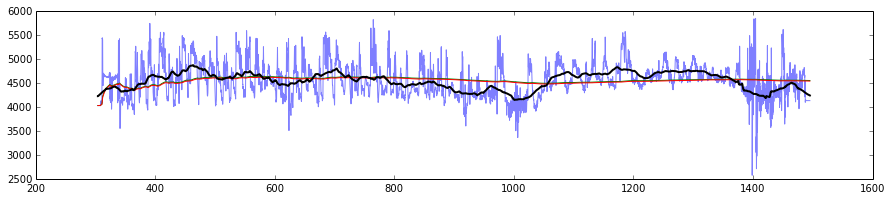

In [36]:
plt.figure(figsize=[15,3])
plt.plot(z_tnt, vp_tnt, alpha=0.5)
plt.plot(z_tnt, rms)
plt.plot(z_tnt, avg)
plt.plot(z_tnt, vp0, 'k', lw=2)
plt.show()

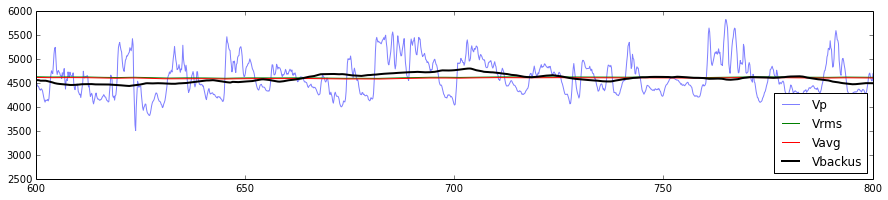

In [37]:
plt.figure(figsize=[15,3])
plt.plot(z_tnt, vp_tnt, alpha=0.5, label='Vp')
plt.plot(z_tnt, rms, label='Vrms')
plt.plot(z_tnt, avg, label='Vavg')
plt.plot(z_tnt, vp0, 'k', lw=2, label='Vbackus')
plt.xlim((600,800))
plt.legend(loc='best')
plt.show()

Compute *Q*p and *Q*s from Liner (2014) equation 10:

In [38]:
ptemp = np.pi * np.log(vp0 / vp_tnt) / (np.log(vp0 / vp_tnt) + np.log(lb/dz))
Qp = 1.0 / np.tan(ptemp)
                  
stemp = np.pi * np.log(vs0 / vs_tnt) / (np.log(vs0 / vs_tnt) + np.log(lb/dz))
Qs = 1.0 / np.tan(stemp)

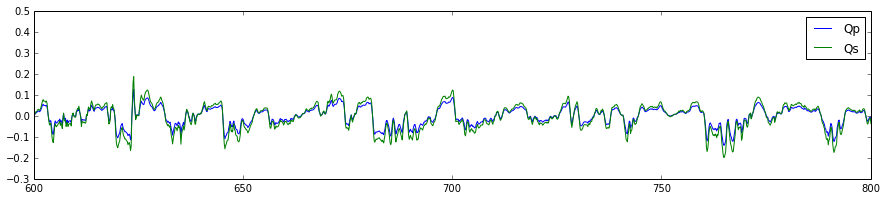

In [39]:
plt.figure(figsize=[15,3])
plt.plot(z_tnt, 1/Qp, label='Qp')
plt.plot(z_tnt, 1/Qs, label='Qs')
plt.xlim((600,800))
plt.legend()
plt.show()

## Reproduce Figure 3

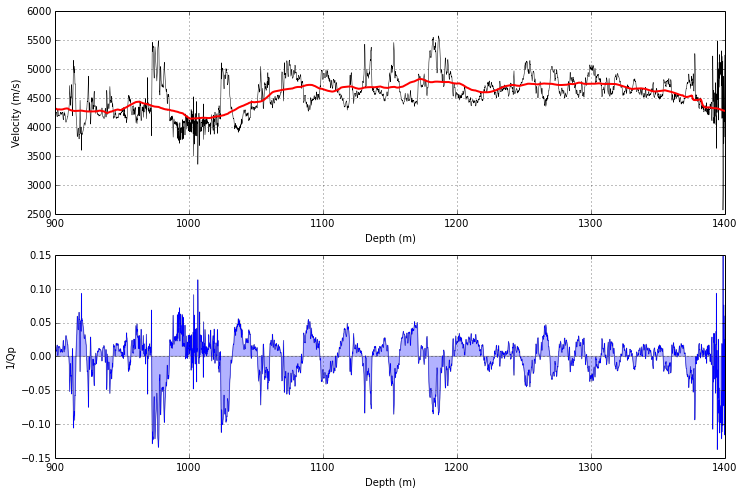

In [40]:
plt.figure(figsize=[12,8])

plt.subplot(211)
plt.plot(z_tnt, vp_tnt, 'k', lw=0.5)
plt.plot(z_tnt, vp0, 'r', lw=2)
plt.xlim(900,1400) # Can also do as tuple or as kwargs
plt.grid()
plt.ylabel('Velocity (m/s)')
plt.xlabel('Depth (m)')

plt.subplot(212)
plt.plot(z_tnt, 1/Qp, lw=0.5)
plt.xlim(900,1400)
plt.ylim((-0.15, 0.15))
plt.fill_between(z_tnt, 1/Qp, alpha=0.3)
plt.grid()
plt.ylabel('1/Qp')
plt.xlabel('Depth (m)')

plt.show()

## Compute Thomsen parameters

Now from Line & Fei1 (2006) we can compute the Thomsen parameters. 

Liner, C, and T Fei1 (2006). Layer-induced seismic anisotropy from full-wave sonic logs:
Theory, application, and validation. *Geophysics* **71** (6), p D183–D190. [DOI:10.1190/1.2356997](http://dx.doi.org/10.1190/1.2356997)

$$\epsilon = \frac{A-C}{2C}$$

$$\delta = \frac{(F+L)^2 - (C-L)^2}{2C(C-L)}$$

$$\gamma = \frac{M-L}{2L}$$

In [41]:
epsilon = (A - C) / (2.0 * C)
delta = ((F + L)**2.0 - (C - L)**2.0) / (2.0 * C * (C - L))
gamma = (M - L) / (2.0 * L)

Now we can reproduce Liner & Feil's figure 1:

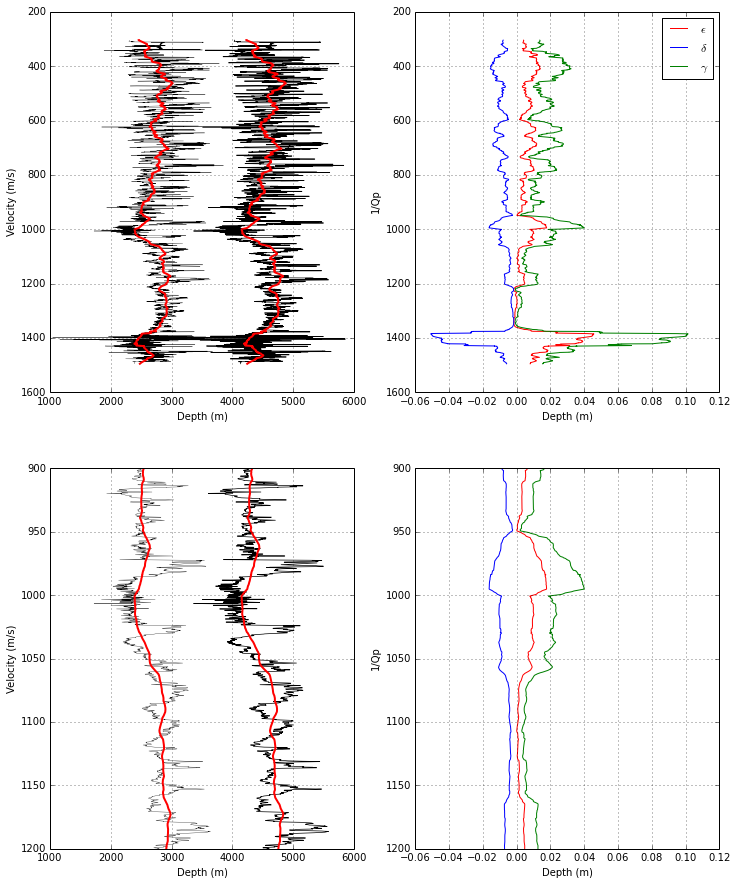

In [42]:
plt.figure(figsize=[12,15])

plt.subplot(221)
plt.plot(vp_tnt, z_tnt, 'k', lw=0.7)
plt.plot(vp0, z_tnt, 'r', lw=2)
plt.plot(vs_tnt, z_tnt, 'k', lw=0.3)
plt.plot(vs0, z_tnt, 'r', lw=2)
plt.gca().invert_yaxis()
plt.grid()
plt.ylabel('Velocity (m/s)')
plt.xlabel('Depth (m)')

plt.subplot(222)
plt.plot(epsilon, z_tnt, 'r', label='$\epsilon$')
plt.plot(delta, z_tnt, 'b', label='$\delta$')
plt.plot(gamma, z_tnt, 'g', label='$\gamma$')
plt.gca().invert_yaxis()
plt.grid()
plt.ylabel('1/Qp')
plt.xlabel('Depth (m)')
plt.legend(loc='best')

plt.subplot(223)
plt.plot(vp_tnt, z_tnt, 'k', lw=0.7)
plt.plot(vp0, z_tnt, 'r', lw=2)
plt.plot(vs_tnt, z_tnt, 'k', lw=0.3)
plt.plot(vs0, z_tnt, 'r', lw=2)
plt.gca().invert_yaxis()
plt.ylim(1200,900) 
plt.grid()
plt.ylabel('Velocity (m/s)')
plt.xlabel('Depth (m)')

plt.subplot(224)
plt.plot(epsilon, z_tnt, 'r')
plt.plot(delta, z_tnt, 'b')
plt.plot(gamma, z_tnt, 'g')
plt.gca().invert_yaxis()
plt.ylim(1200,900)
plt.grid()
plt.ylabel('1/Qp')
plt.xlabel('Depth (m)')

plt.show()

I think the funky $\delta$ values are a result of the modeled $V_\mathrm{S}$ curve.

Thomsen RGB?

## Compute dispersion

Kjartansson (1979) --- *Journal of Geophysical Research*, **84** (B9), 4737-4748. [DOI: 10.1029/JB084iB09p04737](http://dx.doi.org/10.1029/JB084iB09p04737) --- demonstrated a constant-*Q* theory. This is how we computed *Q* in the last section, using a rearranged version of this equation:

$$V(f) = V_0 \left( \frac{f}{f_0} \right)^\gamma$$

or

$$V(f) = V_0 \left( \frac{f}{V_0/\lambda_0} \right)^\gamma$$

where

$$\gamma = \frac{1}{\pi} \tan^{-1} \left( \frac{1}{Q} \right)$$

So now that we know *Q*, given that it's constant (for each layer, i.e. for each log sample), we can use it to compute any velocity *V*.

In [43]:
gamma = np.arctan(1/Qp) / np.pi
gamma.shape

(7815,)

In [44]:
#freqs = np.linspace(5, 250)
#freqs.shape

freqs = np.logspace(0,4)
freqs

array([  1.00000000e+00,   1.20679264e+00,   1.45634848e+00,
         1.75751062e+00,   2.12095089e+00,   2.55954792e+00,
         3.08884360e+00,   3.72759372e+00,   4.49843267e+00,
         5.42867544e+00,   6.55128557e+00,   7.90604321e+00,
         9.54095476e+00,   1.15139540e+01,   1.38949549e+01,
         1.67683294e+01,   2.02358965e+01,   2.44205309e+01,
         2.94705170e+01,   3.55648031e+01,   4.29193426e+01,
         5.17947468e+01,   6.25055193e+01,   7.54312006e+01,
         9.10298178e+01,   1.09854114e+02,   1.32571137e+02,
         1.59985872e+02,   1.93069773e+02,   2.32995181e+02,
         2.81176870e+02,   3.39322177e+02,   4.09491506e+02,
         4.94171336e+02,   5.96362332e+02,   7.19685673e+02,
         8.68511374e+02,   1.04811313e+03,   1.26485522e+03,
         1.52641797e+03,   1.84206997e+03,   2.22299648e+03,
         2.68269580e+03,   3.23745754e+03,   3.90693994e+03,
         4.71486636e+03,   5.68986603e+03,   6.86648845e+03,
         8.28642773e+03,

Make repeat versions of the log-likes, across all freqs, so we end up with something we can `plt.imshow()`. 

In [45]:
v_freqs = np.reshape(np.repeat(vp0, freqs.size),(vp0.size, freqs.size))
gamma_repeat = np.reshape(np.repeat(gamma, freqs.size),(gamma.size, freqs.size))

In [46]:
v_disp = v_freqs * (freqs/(v_freqs/lb)) ** gamma_repeat

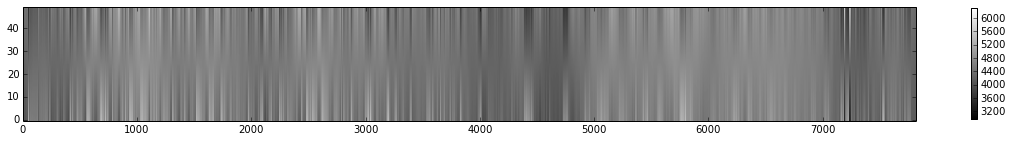

In [47]:
# easier to work with transposed
result = np.transpose(v_disp)
plt.figure(figsize=(20,4))
plt.imshow(result, cmap='gray', origin="lower", aspect=20)
plt.colorbar(shrink=0.5)
plt.savefig('V_with_f_vs_depth.png', dpi=125)
plt.show()


Notice that many layers are relatively fast (bright) at low frequencies (top of the plot), but relatively slow at high frequencies. This is the implication of Liner's Figure 5 (in the TLE article). What is this *f* at which we have the least velocity contrast? 

## Sven's question

What difference does the Backus length make? (Chris chose it because it works out as a peak frequency of 125 Hz, given the peak velocity). 

In [48]:
range_low = 1
range_high = 50
lb_range = np.linspace(range_low, range_high, 100)
lb_range.shape

(100,)

In [49]:
vp_range = np.reshape(np.repeat(vp_tnt, lb_range.size),(vp_tnt.size, lb_range.size))
rho_range = np.reshape(np.repeat(rho_tnt, lb_range.size),(rho_tnt.size, lb_range.size))
rho_range.shape

(7815, 100)

In [50]:
Lr = np.reshape(np.repeat(L, lb_range.size),(rho_tnt.size, lb_range.size))
Cr = np.reshape(np.repeat(C, lb_range.size),(rho_tnt.size, lb_range.size))
Cr.shape

(7815, 100)

In [51]:
R = np.empty_like(rho_range)
for i in range(lb_range.size):
    R[:,i] = moving_average(rho_tnt, lb_range[i]/dz, mode='same')
vp0 = np.sqrt(Cr / R)
vs0 = np.sqrt(Lr / R)

Originally, `moving_average()` was sending back one sample too many... Now I check for the 'same' length, and fix it if it's not the same, taking 'between' points, average of each pair, which should have length-1. 

In [52]:
print vp0.shape, vp_range.shape
ptemp = np.pi * np.log(vp0 / vp_range) / (np.log(vp0 / vp_range) + np.log(lb/dz))
Qp = 1.0 / np.tan(ptemp)

(7815, 100) (7815, 100)


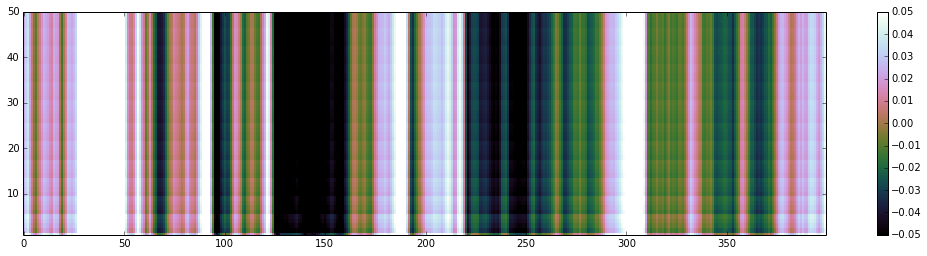

In [53]:
plt.figure(figsize=(18,4))
plt.imshow(1/Qp.T[:,800:1200], aspect="auto", origin="lower", vmin=-0.05, vmax=0.05, cmap="cubehelix", interpolation="none")
plt.ylim((range_low, range_high))
plt.colorbar()
plt.show()

The *x*-axis is depth. The *y*-axis is the length of the Backus operator in metres. The colour is the value of 1/*Q*.

Let's zoom in so we can see these textures...

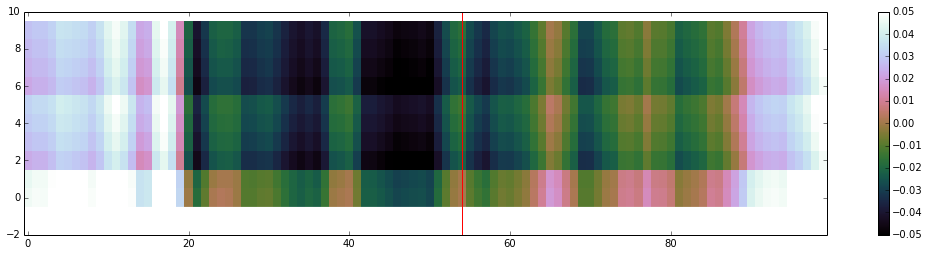

In [54]:
vline=54
plt.figure(figsize=(18,4))
plt.imshow(1/Qp.T[:10,1000:1100], aspect="auto", origin="lower", vmin=-0.05, vmax=0.05, cmap="cubehelix", interpolation="none")
plt.vlines(vline, -2, 10, "r")
plt.colorbar()
plt.show()

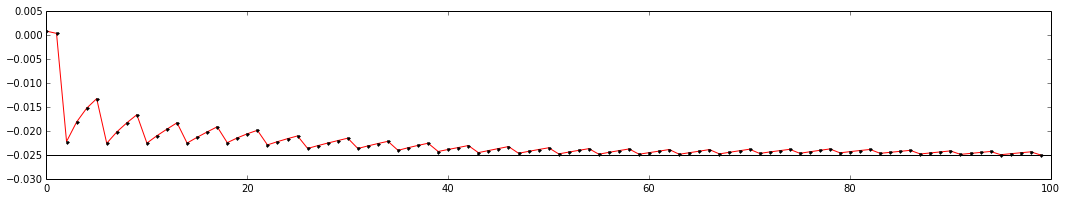

In [55]:
plt.figure(figsize=(18,3))
plt.plot(1/Qp[1054,:], "r")
plt.plot(1/Qp[1054,:], "k.")
plt.hlines(-0.025, 0, 100)
plt.show()

This is a 'transect' across the operator lengths. The *x*-axis is operator length, the *y*-axis is 1/*Q*. Completely by eyeball, it looks like the asymptote is 1/*Q* = ca. -0.025. After a length of about 40 m, in this case, it looks pretty stable / low variance. [NB Need to ceck that these are, indeed, real units.]

## Implementation

What's the best way to implement this in `agilegeo`?

- Already have something to compute elastic moduli, essentially replacing Liner's equation 2
- Make sure existing routines can compute in any dimension, e.g. pass in logs (vectors) instead of scalars
- Maybe this is a module `anisotropy()`, that calls on `moduli()` and returns $V_\mathrm{P0}$, $V_\mathrm{S0}$, $\epsilon$, $\delta$, and $\gamma$
- Then need another module, `attenuation()` that takes $V_\mathrm{P0}$, plus frequencies or wavelengths, and returns *Q*

## Enhancements

- Top and tail a set of logs according to whichever has the least data.
- Better yet, model the missing data.